# Optimizing Running Performance and Efficiency with Neural Network Models

This notebook is a tool for analyzing and optimizing the performance of a running athlete. It begins by calculating various performance indices, such as VO2max (an indicator of aerobic fitness) adjusted for altitude, vVo2Max (running pace at Vo2Max), activity running speed adjusted for gradient, and the running efficiency factor (Running efficiency predictor). These values are then combined with other data, including TSS (Training Stress Score), RMSSD (Root Mean Square of the HRV Successive Differences), and nutrition data (Fiber intake).

The combined data is then split into 21-day blocks (with mean values) and fed into neural network models (MLPRegressor) to determine the "Peak performance zone," in which the athlete is most efficient, and the "Caution zone," in which they are least efficient. The corresponding training intensities/volume (TSS) and recovery metric (RMSSD) are also determined. Finally, the results are plotted on scatter and timeline plots, along with efficiency bands, to visualize the analysis.

The purpose of this notebook is to potentially help the athlete determine the optimal training intensities and volume and inform tapering before races in order to achieve the best performance and training adaptation. The data used for this analysis is from a single masters athlete and covers a period of 20 months of training at various intensities, on different terrains, at different altitudes, and with different nutritional interventions. The data is retrieved from "Athlete Data Warehouse" PostgreSQL database that combines various athletic activity/livestyle data from various sources, and exported into CSV included with this notebook.

Resources:
* https://github.com/pgalko/athlete_data_warehouse
* https://alancouzens.com/blog/Banister_v_Neural_Network.html,
* https://www.academia.edu/18970413/Heart_Rate_Running_Speed_index_May_Be_an_Efficient_Method_of_Monitoring_Endurance_Training_Adaptation,
* https://www.runnersworld.com/training/a20829802/tracking-fitness-with-the-heart-rate-running-speed-index/,
* https://dyrts.fr/en/posts/vvo2max/,
* https://pickletech.eu/blog-gap/,
* https://educatedguesswork.org/posts/grade-vs-pace/


Import the required Python libraries

In [259]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from scipy.stats import gaussian_kde

Define the function for adding 1% to a VO2max for every 122 meters of altitude above 1520m

In [260]:
def increase_vo2max_by_1_percent(vo2max, altitude):
  if altitude > 1520:
    # Calculate the number of 122 meter increments above 1520 meters
    increment = (altitude - 1520) / 122
    # Add 1% to VO2max for each increment
    vo2max += vo2max * 0.01 * increment
    return vo2max
  else:
    return vo2max

Define the function for calculating VO2max velocity,duration and altitude using Daniels/Gilbert formula

In [261]:
def VO2Max(velocity,duration,altitude):
    #Convert duration from seconds to minutes
    time = duration/60
    #Convert velocity from meters/sec meters/min
    velocity = velocity*60
    #Daniels/Gilbert VO2max formula
    vo2max = ((0.000104 * (velocity**2)) + (0.182258 * velocity) - (4.6)) / ((0.1894393 * (math.exp(-0.012778 * time))) + (0.2989558 * (math.exp(-0.1932605 * time))) + 0.8)
    #Adjust VO2max for altitude
    vo2max = increase_vo2max_by_1_percent(vo2max, altitude)
    return vo2max


Define the function for calculating running index using Nummela/Vesterinen formula (https://www.academia.edu/18970413/Heart_Rate_Running_Speed_index_May_Be_an_Efficient_Method_of_Monitoring_Endurance_Training_Adaptation)

In [262]:
def calculate_running_index_hr_rs(peak_speed,duration,distance,HR,HRmax,HRrest):
  # Parameters:
  # peak_speed (100% vVO2max) in seconds per km
  # run_time in seconds
  # distance in meters (adjusted for gradient)
  # HR in bpm

  # convert run_time to minutes
  duration=duration/60
  # convert distance to km
  distance=(distance)/1000
  # avg_speed in km/h
  avg_speed = distance / (duration / 60)
  # convert peak speed in seconds per km to km/h
  peak_speed = 3600 / peak_speed
  # calculate HRstanding
  hr_standing = HRrest + 26
  slope = (HRmax - hr_standing) / peak_speed
  running_index = avg_speed - ((HR - hr_standing) / slope)
  return running_index

Create a dataframe from the csv file

In [263]:
data_run = pd.read_csv("db_efficiency_factor_pred_run.csv")

In [264]:
print(data_run)

      athlete_id  local_date  gmt_offset  wellness_resting_heart_rate  \
0              1  2023-01-26        11.0                           41   
1              1  2023-01-25        11.0                           42   
2              1  2023-01-24        11.0                           43   
3              1  2023-01-23        11.0                           41   
4              1  2023-01-22        11.0                           46   
...          ...         ...         ...                          ...   
3709           1  2015-05-26        10.0                            0   
3710           1  2015-05-23        10.0                            0   
3711           1  2015-05-21        10.0                            0   
3712           1  2015-05-17        10.0                            0   
3713           1  2015-05-16        10.0                            0   

     act_type  act_daily_suffer_score  act_pmc_atl  act_pmc_ctl  act_pmc_tsb  \
0         NaN                       0      

Convert date column to datetime

In [265]:
data_run['local_date'] = pd.to_datetime(data_run['local_date'])

Delete rows with date's before the required date. No RMSSD data available befor 2021-04-01

In [266]:
data_run = data_run[~(data_run['local_date'] < '2021-04-01')]

Calculate average resting heartrate from column 'wellness_resting_heart_rate'

In [267]:
HRrest = data_run['wellness_resting_heart_rate'].mean()

Pick the maximum heartrate from the column 'act_max_heartrate' and discard outliers

In [268]:
HRmax = data_run['act_max_heartrate'].quantile(0.95)

Drop rows with Nan in act_type column

In [269]:
data_run = data_run.dropna(subset=['act_type'])

Calculate VO2max for each run and add it to a new column 'vo2max_run'

In [270]:
for index, row in data_run.iterrows():
  if "Run" in row['act_type']:
    data_run.loc[index,'vo2max_run'] = VO2Max(row['act_gap'],row['act_duration'],row['act_altitude'])

Select highest value from the column 'vo2max_run' for the most current 30 runs and discard outliers

In [271]:
vo2max_run = data_run[data_run['act_type'].str.contains('Run')].nlargest(30,'vo2max_run')['vo2max_run'].quantile(0.95)

Calculate vVO2max from vo2max_run using Leger et al. (2012) formula (Garmin uses this formula for their vVO2max estimation). 
I have modified the constant from 3.5 to 3.25 to give a closer estimate for highly trained individuals.

In [272]:
vvo2max_run = 3600/(vo2max_run/3.25) #this gives output in sec per km

Calculate running index for each run and add it to a new column 'ef_run'

In [273]:
for index, row in data_run.iterrows():
  if "Run" in row['act_type']:
    data_run.loc[index,'ef_run'] = calculate_running_index_hr_rs(vvo2max_run,row['act_duration'],row['act_distance'],row['act_heart_rate'],HRmax,HRrest)
    data_run.loc[index,'act_gap_run'] = row['act_gap']
    data_run.loc[index,'act_hr_run'] = row['act_heart_rate']
    data_run.loc[index,'act_tss_run'] = row['act_daily_suffer_score']
    data_run.loc[index,'act_distance_run'] = row['act_distance']/1000

Drop ef_run and act_hr_run values greater than 3 standard deviations from the mean

In [274]:
data_run = data_run[~(np.abs(data_run['ef_run'] - data_run['ef_run'].mean()) > (3 * data_run['ef_run'].std()))]
data_run = data_run[~(np.abs(data_run['act_hr_run'] - data_run['act_hr_run'].mean()) > (3 * data_run['act_hr_run'].std()))]

Set variables and data columns to feed to dhe ML moden and matlotlib plots

In [275]:
# Define the number of days that will go in to each block. The 'n' value depends on the amount of data available.
block_len = 21
# Define the metric to be used for TSS calculation (column name in the dataframe)
tss_metric = 'act_pmc_ctl'
# Define the metric  to be used for efficiency calculation (column name in the dataframe)
run_efficiency_metric = 'ef_run'
# the current value of oura_rmssd_baseline
rmssd_baseline = data_run['oura_sleep_baseline'].iloc[-1]
#compute mean of ef_run, and assign to ef_baseline variable
ef_baseline = data_run['ef_run'].mean()
#compute mean of act_gap, and assign to gap_baseline variable
gap_baseline = data_run['act_gap_run'].mean()
#compute mean of act_hr_run, and assign to hr_baseline variable
hr_baseline = data_run['act_hr_run'].mean()
#compute mean of act_distance, and assign to distance_baseline variable
distance_baseline = data_run['act_distance_run'].mean()

Create empty lists to store the values for each block

In [276]:
ef_run_block = []
tss_block =[]
time_block = []
rmssd_block = []
bmi_block = []
altitude_block = []
act_count_block = []
nutr_fiber_block = []
act_hr_block = []
act_gap_block = []
act_distance_block = []

Loop through the dataframe and calculate the mean values for each block

In [277]:
for value in range(0, len(data_run[run_efficiency_metric]), block_len):
    ef_run_block.append(data_run[run_efficiency_metric][value:value+block_len].mean())
    act_count_block.append(data_run[run_efficiency_metric][value:value+block_len].count())
    tss_block.append(data_run[tss_metric][value:value+block_len].mean())
    time_block.append(data_run['local_date'][value:value+block_len].mean())
    rmssd_block.append(data_run['oura_sleep_rmssd'][value:value+block_len].mean())
    altitude_block.append(data_run['act_altitude'][value:value+block_len].mean())
    nutr_fiber_block.append(data_run['nutr_daily_fiber'][value:value+block_len].mean())
    act_hr_block.append(data_run['act_hr_run'][value:value+block_len].mean())
    act_gap_block.append(data_run['act_gap_run'][value:value+block_len].mean())
    act_distance_block.append(data_run['act_distance_run'][value:value+block_len].sum())

Replace NaN values with mean in the ef_run_block,act_gap_block,act_hr_block and rmssd_block lists

In [278]:
ef_run_block = [ef_baseline if np.isnan(x) else x for x in ef_run_block]
rmssd_block = [rmssd_baseline if np.isnan(x) else x for x in rmssd_block]
act_gap_block = [gap_baseline if np.isnan(x) else x for x in act_gap_block]
act_hr_block = [hr_baseline if np.isnan(x) else x for x in act_hr_block]
act_distance_block = [distance_baseline if np.isnan(x) else x for x in act_distance_block]

Replace values 0 with 1 in the act_count_block list

In [279]:
act_count_block = [0.2 if x == 0 else x for x in act_count_block]

Define the Neural Network Model to predict EF from TSS,RMSSD and Nutrition, and set the hyperparameters

In [280]:
model = MLPRegressor(hidden_layer_sizes=(200,100,50,25,10),max_iter = 5000, activation='relu',solver='adam',alpha=0.1,learning_rate='adaptive',random_state=8)
# Fit the model to predict ef_run_block from tss_block,rmssd_block and nutr_fiber block
model.fit(np.column_stack((tss_block,rmssd_block,act_distance_block,act_count_block,nutr_fiber_block)), ef_run_block)
# Make a prediction and store in the yhat variable
yhat = model.predict(np.column_stack((tss_block,rmssd_block,act_distance_block,act_count_block,nutr_fiber_block)))
# compute the rmse and mape
rmse = np.sqrt(mean_squared_error(ef_run_block, yhat))
mape = mean_absolute_percentage_error(ef_run_block, yhat)

Print the results

In [281]:
print('Run EF RMSE: %.3f' % rmse)
print('Run EF MAPE: %.3f' % mape)

Run EF RMSE: 0.074
Run EF MAPE: 0.115


Define the Neural Network Model to predict RMSSD from TSS,EF and Nutrition, and set the hyperparameters

In [282]:
rmssd_model = MLPRegressor(hidden_layer_sizes=(400,200,100,50,25,10),max_iter = 5000, activation='relu',solver='adam',alpha=0.1,learning_rate='adaptive',random_state=8)
# Fit the model to predict ef_run_block from tss_block,ef_run_block and nutr_fiber block
rmssd_model.fit(np.column_stack((tss_block,ef_run_block,act_distance_block,nutr_fiber_block)), rmssd_block)
# Make a prediction and srore in the rmssd_yhat variable
rmssd_yhat = rmssd_model.predict(np.column_stack((tss_block,ef_run_block,act_distance_block,nutr_fiber_block)))
# compute the rmse and mape
rmse = np.sqrt(mean_squared_error(rmssd_block, rmssd_yhat))
mape = mean_absolute_percentage_error(rmssd_block, rmssd_yhat)

Print the results

In [283]:
print('Run RMSSD RMSE: %.3f' % rmse)
print('Run RMSSD MAPE: %.3f' % mape)

Run RMSSD RMSE: 4.967
Run RMSSD MAPE: 0.064


Define the Neural Network Model to predict Velocity from TSS and Nutrition, and set the hyperparameters

In [284]:
gap_model = MLPRegressor(hidden_layer_sizes=(200,100,50,25,10),max_iter = 5000, activation='relu',solver='adam',alpha=0.1,learning_rate='adaptive',random_state=8)
# Fit the model to predict act_gap_block from tss_block,act_hr_block and nutr_fiber block
gap_model.fit(np.column_stack((tss_block,act_hr_block,act_distance_block,nutr_fiber_block)), act_gap_block)
# Make a prediction and store in the gap_yhat variable
gap_yhat = gap_model.predict(np.column_stack((tss_block,act_hr_block,act_distance_block,nutr_fiber_block)))
# compute the rmse and mape
rmse = np.sqrt(mean_squared_error(act_gap_block, gap_yhat))
mape = mean_absolute_percentage_error(act_gap_block, gap_yhat)

Print the results

In [285]:
print('Run GAP RMSE: %.3f' % rmse)
print('Run GAP MAPE: %.3f' % mape)

Run GAP RMSE: 0.070
Run GAP MAPE: 0.015


Define the Neural Network Model to predict Run HR from TSS,GAP and Nutrition, and set the hyperparameters

In [286]:
hr_model = MLPRegressor(hidden_layer_sizes=(400,200,100,50,25,10),max_iter = 5000, activation='relu',solver='adam',alpha=0.1,learning_rate='adaptive',random_state=8)
# Fit the model to predict act_hr_block from tss_block,act_gap_block and nutr_fiber block
hr_model.fit(np.column_stack((tss_block,act_gap_block,act_distance_block,nutr_fiber_block)), act_hr_block)
# Make a prediction and store in the hr_yhat variable
hr_yhat = hr_model.predict(np.column_stack((tss_block,act_gap_block,act_distance_block,nutr_fiber_block)))
# compute the rmse and mape
rmse = np.sqrt(mean_squared_error(act_hr_block, hr_yhat))
mape = mean_absolute_percentage_error(act_hr_block, hr_yhat)

Print the results

In [287]:
print('Run HR RMSE: %.3f' % rmse)
print('Run HR MAPE: %.3f' % mape)

Run HR RMSE: 3.415
Run HR MAPE: 0.019


Plot on a scatter plot the tss_block on x axes ef_run_block on y axes and rmssd_block on second y axes (right)

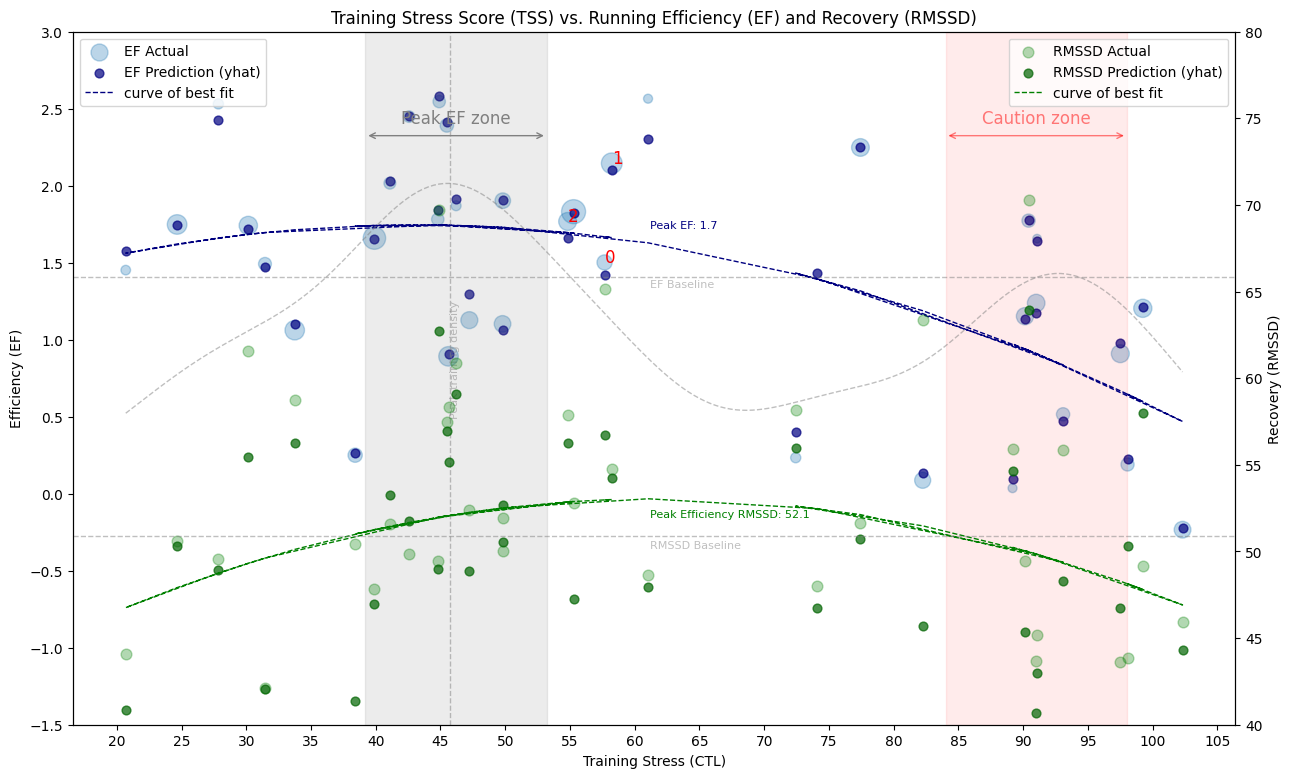

In [288]:
# compute and plot the size based on the number of activities in the block (largest number = largest size)
size = (act_distance_block - np.min(act_distance_block))/(np.max(act_distance_block) - np.min(act_distance_block))*300
fig, ax1 = plt.subplots(figsize=(15, 9))
# on a scatter plot the tss_block on x axes and ef_run_block on y axes
ax1.scatter(tss_block, ef_run_block,s=size,alpha=0.3)
ax1.set_xlabel('Training Stress (CTL)')
ax1.set_ylabel('Efficiency (EF)')
# on a scatter plot the tss_block on x axes and yhat on y axes
ax1.scatter(tss_block, yhat, s=40, c='navy', alpha=0.7)
ax1.set_ylim(-1.5,3)
#set xticks for the x axis
ax1.set_xticks(np.arange(0,150,5))
# compute and plot a curved line of best fit
z = np.polyfit(tss_block, yhat, 2)
p = np.poly1d(z)
ax1.plot(tss_block,p(tss_block),linewidth=1, color='navy', linestyle='--')
# compute and plot the training density curve 
density = gaussian_kde(tss_block)
xs = np.linspace(min(tss_block), max(tss_block), 200)
density.covariance_factor = lambda : .25
density._compute_covariance()
ax1.plot(xs,density(xs)*100,linewidth=1, color='grey', alpha=0.5, linestyle='--')
# mark the highest density with a vertical line
max_density_index = np.argmax(density(xs))
#add text to the line
ax1.text(xs[max_density_index], 0.5, 'Peak training density', rotation=90, color='grey', alpha=0.5, fontsize=8)
ax1.axvline(x=xs[max_density_index], linewidth=1,color='grey', alpha=0.5, linestyle='--')
# for each yhat point take 'n' preceding values and 'n' following values and compute the average. Store the averages in a list. 
# find an index of the point with the highest and lowest average and mark with a vertical band +-7 tss values
# define the rolling window size (needs to be even number)
window_size = 10
window_size_half = int(window_size/2)
yhat_avg = []
for i in range(0, len(yhat)):
    if i < window_size_half:
        yhat_avg.append(np.mean(yhat[0:i+window_size_half]))
    elif i > len(yhat)-window_size_half:
        yhat_avg.append(np.mean(yhat[i-window_size_half:]))
    else:
        yhat_avg.append(np.mean(yhat[i-window_size_half:i+window_size_half]))
# find the index of the highest average and store in peak_tss variable
max_yhat_avg_index = np.argmax(yhat_avg)
peak_tss = tss_block[max_yhat_avg_index]
# find the index of the lovest average and store in danger_tss variable
min_yhat_avg_index = np.argmin(yhat_avg)
danger_tss = tss_block[min_yhat_avg_index]
# print the value of the intersect of peak_tss and the line of best fit.
ax1.text(peak_tss+15, p(peak_tss), 'Peak EF: ' + str(round(p(peak_tss),1)), ha='left', va='center', color='navy', fontsize=8)
#mark max_rolling index with a band +-7 from the peak_tss
ax1.axvspan(peak_tss-7,peak_tss+7, alpha=0.15, color='grey')
#mark min_rolling index with a band +-7 from the danger_tss
ax1.axvspan(danger_tss-7,danger_tss+7, alpha=0.08, color='red')
# draw a horizontal line at ef_baseline on the left y axis
ax1.axhline(y=ef_baseline, linewidth=1,color='grey', alpha=0.5, linestyle='--')
# add text to the baseline
ax1.text(peak_tss+15, ef_baseline-0.05, 'EF Baseline', ha='left', va='center', color='grey', alpha=0.5, fontsize=8)
# Find the 3 most current training blocks and annotate with 0 for the current, 1 for the next one back and 2 for the third one back
for i, txt in enumerate([0,1,2]):
    ax1.annotate(txt, (tss_block[i], ef_run_block[i]), fontsize=12, color='red')

# set the second y-axis
ax2 = ax1.twinx()
# on a scatter plot the tss_block on x axes and rmssd_block on y axes
ax2.scatter(tss_block, rmssd_block, c='green', s=60,alpha=0.3)
ax2.set_ylabel('Recovery (RMSSD)')
ax2.set_ylim(40,80)
# on a scatter plot the tss_block on x axes and rmssd_yhat on y axes
ax2.scatter(tss_block, rmssd_yhat, s=40, c='darkgreen', alpha=0.7)
# compute and plot a curved line of best fit
z = np.polyfit(tss_block, rmssd_yhat, 2)
p = np.poly1d(z)
ax2.plot(tss_block,p(tss_block),linewidth=1, color='green', linestyle='--')
# draw a horizontal line at rmssd_baseline on the right y axis
ax2.axhline(y=rmssd_baseline, linewidth=1, color='grey', alpha=0.5, linestyle='--')
# add text to the baseline
ax2.text(peak_tss+15, rmssd_baseline-0.5, 'RMSSD Baseline', ha='left', va='center', color='grey', alpha=0.5, fontsize=8)

# print the value of the intersect of peak_tss and the line of best fit.
ax2.text(peak_tss+15, p(peak_tss), 'Peak Efficiency RMSSD: ' + str(round(p(peak_tss),1)), ha='left', va='center', color='green', fontsize=8)

#draw a horizontal arrow between peak_tss-7 and peak_tss+7
ax2.annotate('', xy=(peak_tss+7, 74), xytext=(peak_tss-7, 74), arrowprops=dict(arrowstyle='<->', color='grey', lw=1))
#add text to the arrow
ax2.text((peak_tss-7+peak_tss+7)/2, 75, 'Peak EF zone', ha='center', va='center', color='grey', fontsize=12)
#drow a horizontal arrow between danger_tss-7 and danger_tss +7
ax2.annotate('', xy=(danger_tss+7, 74), xytext=(danger_tss-7, 74), arrowprops=dict(arrowstyle='<->', color='red',alpha=0.5, lw=1))
#add text to the arrow
ax2.text((danger_tss-7+danger_tss+7)/2, 75, 'Caution zone', ha='center', va='center', color='red', alpha=0.5, fontsize=12)
#Legend
ax1.legend(['EF Actual','EF Prediction (yhat)','curve of best fit'],loc='upper left')
ax2.legend(['RMSSD Actual','RMSSD Prediction (yhat)','curve of best fit'],loc='upper right')
#Title
plt.title('Training Stress Score (TSS) vs. Running Efficiency (EF) and Recovery (RMSSD)')
#show the plot slightly larger
plt.show()

Plot on a scatter plot the tss_block on x axes ef_run_block on y axes and act_gap_block on second y axes (right)

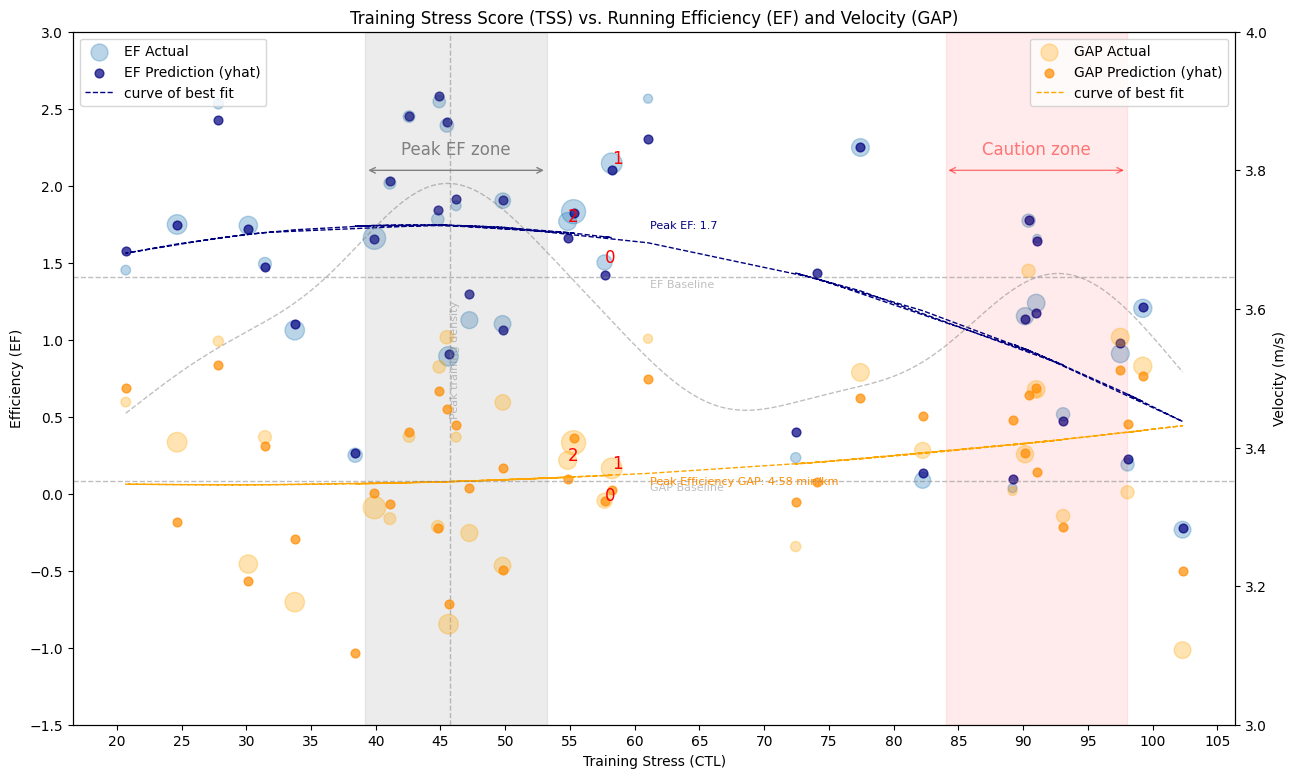

In [289]:
# compute and plot the size based on the number of activities in the block (largest number = largest size)
size = (act_distance_block - np.min(act_distance_block))/(np.max(act_distance_block) - np.min(act_distance_block))*300
fig, ax1 = plt.subplots(figsize=(15, 9))
# on a scatter plot the tss_block on x axes and ef_run_block on y axes
ax1.scatter(tss_block, ef_run_block,s=size,alpha=0.3)
ax1.set_xlabel('Training Stress (CTL)')
ax1.set_ylabel('Efficiency (EF)')
# on a scatter plot the tss_block on x axes and yhat on y axes
ax1.scatter(tss_block, yhat, s=40, c='navy', alpha=0.7)
ax1.set_ylim(-1.5,3)
#set xticks for the x axis
ax1.set_xticks(np.arange(0,150,5))
# compute and plot a curved line of best fit
z = np.polyfit(tss_block, yhat, 2)
p = np.poly1d(z)
ax1.plot(tss_block,p(tss_block),linewidth=1, color='navy', linestyle='--')
# compute and plot the training density curve 
density = gaussian_kde(tss_block)
xs = np.linspace(min(tss_block), max(tss_block), 200)
density.covariance_factor = lambda : .25
density._compute_covariance()
ax1.plot(xs,density(xs)*100,linewidth=1, color='grey', alpha=0.5, linestyle='--')
# mark the highest density with a vertical line
max_density_index = np.argmax(density(xs))
#add text to the line
ax1.text(xs[max_density_index], 0.5, 'Peak training density', rotation=90, color='grey', alpha=0.5, fontsize=8)
ax1.axvline(x=xs[max_density_index], linewidth=1,color='grey', alpha=0.5, linestyle='--')
# for each yhat point take 'n' preceding values and 'n' following values and compute the average. Store the averages in a list. 
# find an index of the point with the highest and lowest average and mark with a vertical band +-7 tss values
# define the rolling window size (needs to be even number)
window_size = 10
window_size_half = int(window_size/2)
yhat_avg = []
for i in range(0, len(yhat)):
    if i < window_size_half:
        yhat_avg.append(np.mean(yhat[0:i+window_size_half]))
    elif i > len(yhat)-window_size_half:
        yhat_avg.append(np.mean(yhat[i-window_size_half:]))
    else:
        yhat_avg.append(np.mean(yhat[i-window_size_half:i+window_size_half]))
# find the index of the highest average and store in peak_tss variable
max_yhat_avg_index = np.argmax(yhat_avg)
peak_tss = tss_block[max_yhat_avg_index]
# find the index of the lovest average and store in danger_tss variable
min_yhat_avg_index = np.argmin(yhat_avg)
danger_tss = tss_block[min_yhat_avg_index]
# print the value of the intersect of peak_tss and the line of best fit.
ax1.text(peak_tss+15, p(peak_tss), 'Peak EF: ' + str(round(p(peak_tss),1)), ha='left', va='center', color='navy', fontsize=8)
#mark max_rolling index with a band +-7 from the peak_tss
ax1.axvspan(peak_tss-7,peak_tss+7, alpha=0.15, color='grey')
#mark min_rolling index with a band +-7 from the danger_tss
ax1.axvspan(danger_tss-7,danger_tss+7, alpha=0.08, color='red')
# draw a horizontal line at ef_baseline on the left y axis
ax1.axhline(y=ef_baseline, linewidth=1,color='grey', alpha=0.5, linestyle='--')
# add text to the baseline
ax1.text(peak_tss+15, ef_baseline-0.05, 'EF Baseline', ha='left', va='center', color='grey', alpha=0.5, fontsize=8)
# Find the 3 most current training blocks and annotate with 0 for the current, 1 for the next one back and 2 for the third one back
for i, txt in enumerate([0,1,2]):
    ax1.annotate(txt, (tss_block[i], ef_run_block[i]), fontsize=12, color='red')

# set the second y-axis
ax2 = ax1.twinx()
# on a scatter plot the tss_block on x axes and rmssd_block on y axes
ax2.scatter(tss_block, act_gap_block, c='orange', s=size,alpha=0.3)
ax2.set_ylabel('Velocity (m/s)')
ax2.set_ylim(3,4)
# on a scatter plot the tss_block on x axes and rmssd_yhat on y axes
ax2.scatter(tss_block, gap_yhat, s=40, c='darkorange', alpha=0.7)
# compute and plot a curved line of best fit
z = np.polyfit(tss_block, gap_yhat, 2)
p = np.poly1d(z)
ax2.plot(tss_block,p(tss_block),linewidth=1, color='orange', linestyle='--')
# draw a horizontal line at gap_baseline on the right y axis
ax2.axhline(y=gap_baseline, linewidth=1, color='grey', alpha=0.5, linestyle='--')
# add text to the baseline
ax2.text(peak_tss+15, gap_baseline-0.01, 'GAP Baseline', ha='left', va='center', color='grey', alpha=0.5, fontsize=8)

# convert the GAP fom m/s to min:sec per km
pace = 1000/(p(peak_tss)*60)
leftover = pace % 1
minutes = pace-leftover
seconds = leftover*60
running_pace = str(int(minutes)) + ':' + str(int(seconds)) + ' min/km'
# print the value of the intersect of peak_tss and the line of best fit.
ax2.text(peak_tss+15, p(peak_tss), 'Peak Efficiency GAP: ' + running_pace, ha='left', va='center', color='darkorange', fontsize=8)

#draw a horizontal arrow between peak_tss-7 and peak_tss+7
ax2.annotate('', xy=(peak_tss+7, 3.8), xytext=(peak_tss-7, 3.8), arrowprops=dict(arrowstyle='<->', color='grey', lw=1))
#add text to the arrow
ax2.text((peak_tss-7+peak_tss+7)/2, 3.83, 'Peak EF zone', ha='center', va='center', color='grey', fontsize=12)
#drow a horizontal arrow between danger_tss-7 and danger_tss +7
ax2.annotate('', xy=(danger_tss+7, 3.8), xytext=(danger_tss-7, 3.8), arrowprops=dict(arrowstyle='<->', color='red',alpha=0.5, lw=1))
#add text to the arrow
ax2.text((danger_tss-7+danger_tss+7)/2, 3.83, 'Caution zone', ha='center', va='center', color='red', alpha=0.5, fontsize=12)
# Find the 3 most current training blocks and annotate with 0 for the current, 1 for the next one back and 2 for the third one back
for i, txt in enumerate([0,1,2]):
    ax2.annotate(txt, (tss_block[i], act_gap_block[i]), fontsize=12, color='red')
#Legend
ax1.legend(['EF Actual','EF Prediction (yhat)','curve of best fit'],loc='upper left')
ax2.legend(['GAP Actual','GAP Prediction (yhat)','curve of best fit'],loc='upper right')
#Title
plt.title('Training Stress Score (TSS) vs. Running Efficiency (EF) and Velocity (GAP)')
#show the plot slightly larger
plt.show()


Plot the tss_metric and the act_pmc_atl on a left y axes and the yhat on the right y axes. plot the local date on the x axes on a new plot.

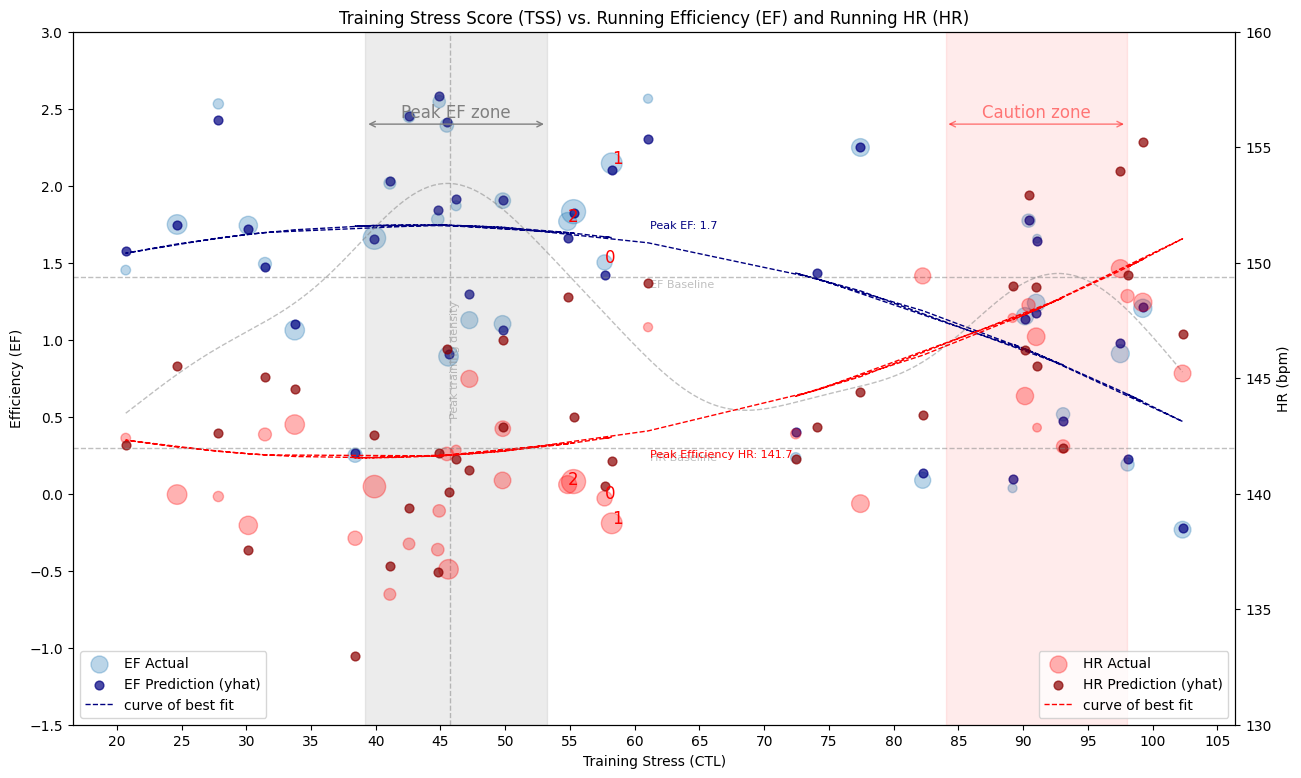

In [290]:
# compute and plot the size based on the number of activities in the block (largest number = largest size)
size = (act_distance_block - np.min(act_distance_block))/(np.max(act_distance_block) - np.min(act_distance_block))*300
fig, ax1 = plt.subplots(figsize=(15, 9))
# on a scatter plot the tss_block on x axes and ef_run_block on y axes
ax1.scatter(tss_block, ef_run_block,s=size,alpha=0.3)
ax1.set_xlabel('Training Stress (CTL)')
ax1.set_ylabel('Efficiency (EF)')
# on a scatter plot the tss_block on x axes and yhat on y axes
ax1.scatter(tss_block, yhat, s=40, c='navy', alpha=0.7)
ax1.set_ylim(-1.5,3)
#set xticks for the x axis
ax1.set_xticks(np.arange(0,150,5))
# compute and plot a curved line of best fit
z = np.polyfit(tss_block, yhat, 2)
p = np.poly1d(z)
ax1.plot(tss_block,p(tss_block),linewidth=1, color='navy', linestyle='--')
# compute and plot the training density curve 
density = gaussian_kde(tss_block)
xs = np.linspace(min(tss_block), max(tss_block), 200)
density.covariance_factor = lambda : .25
density._compute_covariance()
ax1.plot(xs,density(xs)*100,linewidth=1, color='grey', alpha=0.5, linestyle='--')
# mark the highest density with a vertical line
max_density_index = np.argmax(density(xs))
#add text to the line
ax1.text(xs[max_density_index], 0.5, 'Peak training density', rotation=90, color='grey', alpha=0.5, fontsize=8)
ax1.axvline(x=xs[max_density_index], linewidth=1,color='grey', alpha=0.5, linestyle='--')
# for each yhat point take 'n' preceding values and 'n' following values and compute the average. Store the averages in a list. 
# find an index of the point with the highest and lowest average and mark with a vertical band +-7 tss values
# define the rolling window size (needs to be even number)
window_size = 10
window_size_half = int(window_size/2)
yhat_avg = []
for i in range(0, len(yhat)):
    if i < window_size_half:
        yhat_avg.append(np.mean(yhat[0:i+window_size_half]))
    elif i > len(yhat)-window_size_half:
        yhat_avg.append(np.mean(yhat[i-window_size_half:]))
    else:
        yhat_avg.append(np.mean(yhat[i-window_size_half:i+window_size_half]))
# find the index of the highest average and store in peak_tss variable
max_yhat_avg_index = np.argmax(yhat_avg)
peak_tss = tss_block[max_yhat_avg_index]
# find the index of the lovest average and store in danger_tss variable
min_yhat_avg_index = np.argmin(yhat_avg)
danger_tss = tss_block[min_yhat_avg_index]
# print the value of the intersect of peak_tss and the line of best fit.
ax1.text(peak_tss+15, p(peak_tss), 'Peak EF: ' + str(round(p(peak_tss),1)), ha='left', va='center', color='navy', fontsize=8)
#mark max_rolling index with a band +-7 from the peak_tss
ax1.axvspan(peak_tss-7,peak_tss+7, alpha=0.15, color='grey')
#mark min_rolling index with a band +-7 from the danger_tss
ax1.axvspan(danger_tss-7,danger_tss+7, alpha=0.08, color='red')
# draw a horizontal line at ef_baseline on the left y axis
ax1.axhline(y=ef_baseline, linewidth=1,color='grey', alpha=0.5, linestyle='--')
# add text to the baseline
ax1.text(peak_tss+15, ef_baseline-0.05, 'EF Baseline', ha='left', va='center', color='grey', alpha=0.5, fontsize=8)
# Find the 3 most current training blocks and annotate with 0 for the current, 1 for the next one back and 2 for the third one back
for i, txt in enumerate([0,1,2]):
    ax1.annotate(txt, (tss_block[i], ef_run_block[i]), fontsize=12, color='red')

# set the second y-axis
ax2 = ax1.twinx()
# on a scatter plot the tss_block on x axes and rmssd_block on y axes
ax2.scatter(tss_block, act_hr_block, c='red', s=size,alpha=0.3)
ax2.set_ylabel('HR (bpm)')
ax2.set_ylim(130,160)
# on a scatter plot the tss_block on x axes and rmssd_yhat on y axes
ax2.scatter(tss_block, hr_yhat, s=40, c='darkred', alpha=0.7)
# compute and plot a curved line of best fit
z = np.polyfit(tss_block, hr_yhat, 2)
p = np.poly1d(z)
ax2.plot(tss_block,p(tss_block),linewidth=1, color='red', linestyle='--')
# draw a horizontal line at gap_baseline on the right y axis
ax2.axhline(y=hr_baseline, linewidth=1, color='grey', alpha=0.5, linestyle='--')
# add text to the baseline
ax2.text(peak_tss+15, hr_baseline-0.4, 'HR Baseline', ha='left', va='center', color='grey', alpha=0.5, fontsize=8)

# print the value of the intersect of peak_tss and the line of best fit.
ax2.text(peak_tss+15, p(peak_tss), 'Peak Efficiency HR: ' + str(round(p(peak_tss),1)), ha='left', va='center', color='red', fontsize=8)

#draw a horizontal arrow between peak_tss-7 and peak_tss+7
ax2.annotate('', xy=(peak_tss+7, 156), xytext=(peak_tss-7, 156), arrowprops=dict(arrowstyle='<->', color='grey', lw=1))
#add text to the arrow
ax2.text((peak_tss-7+peak_tss+7)/2, 156.5, 'Peak EF zone', ha='center', va='center', color='grey', fontsize=12)
#drow a horizontal arrow between danger_tss-7 and danger_tss +7
ax2.annotate('', xy=(danger_tss+7, 156), xytext=(danger_tss-7, 156), arrowprops=dict(arrowstyle='<->', color='red',alpha=0.5, lw=1))
#add text to the arrow
ax2.text((danger_tss-7+danger_tss+7)/2, 156.5, 'Caution zone', ha='center', va='center', color='red', alpha=0.5, fontsize=12)
# Find the 3 most current training blocks and annotate with 0 for the current, 1 for the next one back and 2 for the third one back
for i, txt in enumerate([0,1,2]):
    ax2.annotate(txt, (tss_block[i], act_hr_block[i]), fontsize=12, color='red')
#Legend
ax1.legend(['EF Actual','EF Prediction (yhat)','curve of best fit'],loc='lower left')
ax2.legend(['HR Actual','HR Prediction (yhat)','curve of best fit'],loc='lower right')
#Title
plt.title('Training Stress Score (TSS) vs. Running Efficiency (EF) and Running HR (HR)')
#show the plot slightly larger
plt.show()

Plot the tss_metric and the act_pmc_atl on a left y axes and the yhat on the right y axes. plot the local date on the x axes on a new plot.

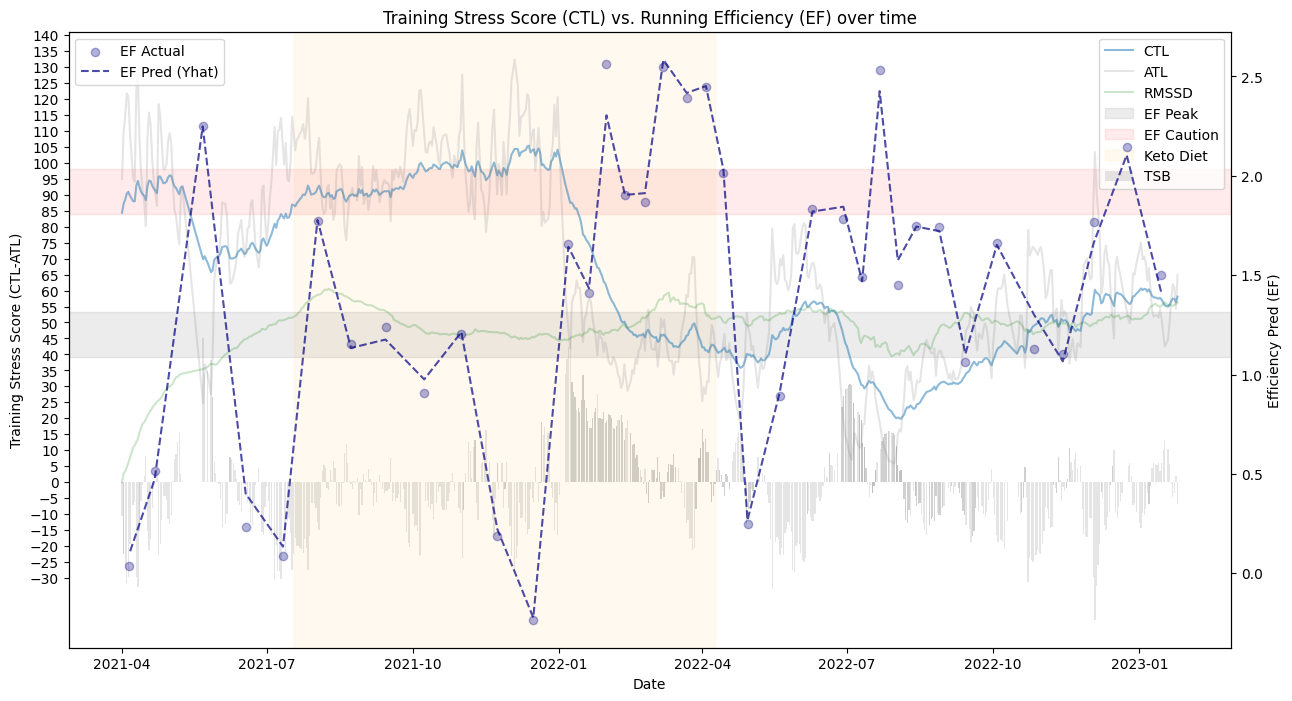

In [291]:
# on a new plot plot the data_run[tss_metric] and the data_run['act_pmc_atl'] on a left y axes and the yhat on the right y axes. plot the local date on the x axes
fig, ax1 = plt.subplots(figsize=(15, 8))
# set the yticks on the left y axes
ax1.set_yticks(np.arange(-30, 200, 5))
#plot the tss_metric
ax1.plot(data_run['local_date'], data_run['act_pmc_ctl'], alpha=0.5)
#plot the act_pmc_atl
ax1.plot(data_run['local_date'], data_run['act_pmc_atl'], alpha=0.2, color='grey')
# #plot as bar the act_pmc_tsb
ax1.bar(data_run['local_date'], data_run['act_pmc_tsb'], alpha=0.2, color='grey')
#plot the oura_sleep_rmssd_42d_ema
ax1.plot(data_run['local_date'], data_run['oura_sleep_rmssd_42d_ema'], alpha=0.2, color='green')
# Labels
ax1.set_xlabel('Date')
ax1.set_ylabel('Training Stress Score (CTL-ATL)')
#plot the tss_peak on a horizontal band
ax1.axhspan(peak_tss-7,peak_tss+7, alpha=0.15, color='grey')
#plot the danger_tss on a horizontal band
ax1.axhspan(danger_tss-7,danger_tss+7, alpha=0.08, color='red')
#draw a vertical band from x-axis 2021-07-18 to 2022-04-09 (Keto Diet)
ax1.axvspan('2021-07-18', '2022-04-09', alpha=0.06, color='orange')

# set the second y axes
ax2 = ax1.twinx()
#plot actual EF
ax2.scatter(time_block,ef_run_block, alpha=0.3, color='navy')
#plot yhat
ax2.plot(time_block, yhat, alpha=0.7, color='navy',linestyle='--')
# ax2 labels
ax2.set_ylabel('Efficiency Pred (EF)')
# ax1 legend
ax1.legend(['CTL','ATL','RMSSD','EF Peak','EF Caution','Keto Diet','TSB'],loc='upper right')
# ax2 legend
ax2.legend(['EF Actual','EF Pred (Yhat)'],loc='upper left')
#title
plt.title('Training Stress Score (CTL) vs. Running Efficiency (EF) over time')
#show the plot
plt.show()